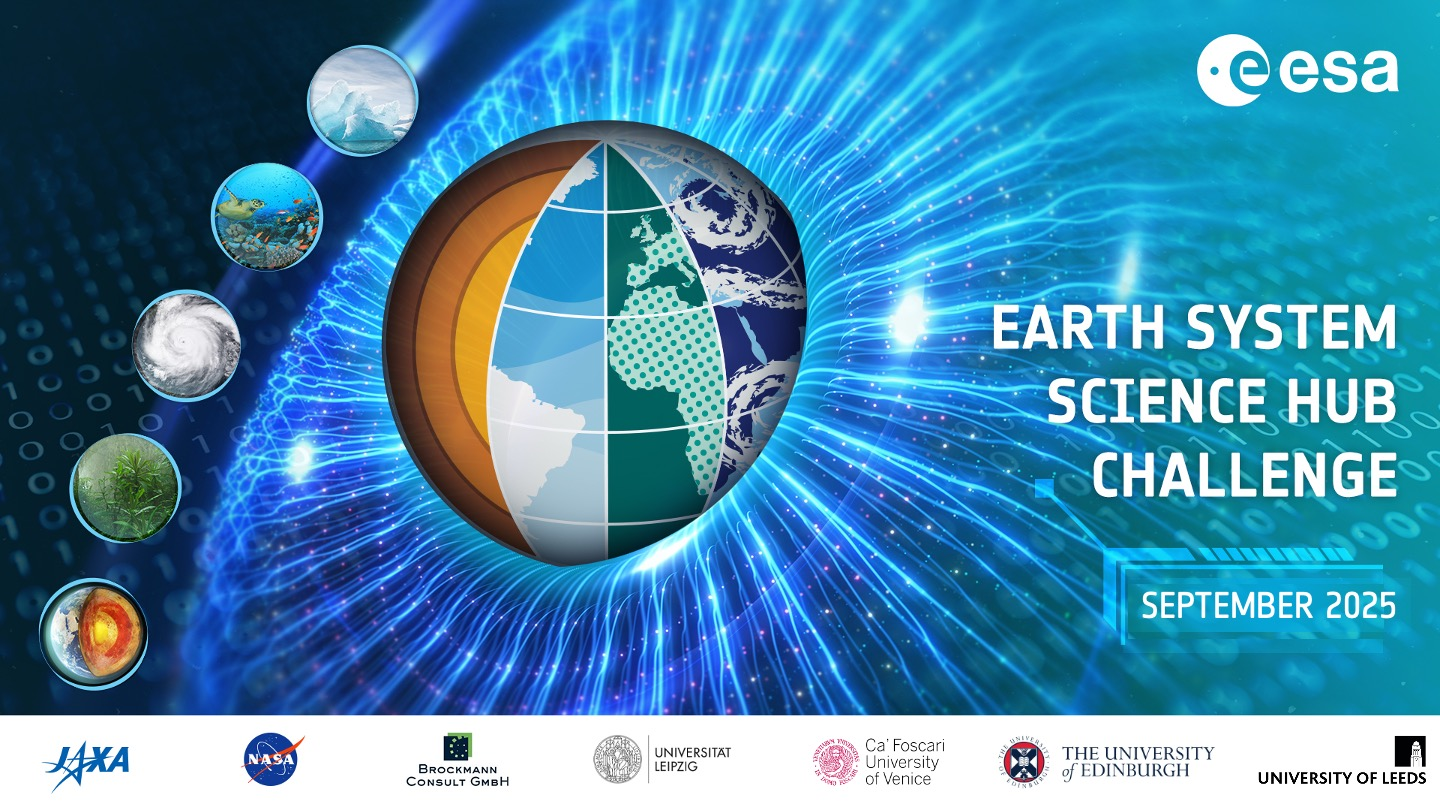

<div class="alert alert-info" role="alert">This concise notebook demonstrates guidelines for submission of your projects developed under the <b>Earth System Science Open Challenge!</b><br>
Please use this notebook as a template for delivering your workflow with the code you used to produce the results! 
<br> 
For more information, refer to Open Challenge website: <a href="https://eo4society.esa.int/event/sciencehubchallengefeb2024/" target="_blank">https://eo4society.esa.int/event/sciencehubchallengefeb2024/ </a> <br> 
</div>

# PART 1: SUMMARY

<hr>

# <a id='section1'></a><span style='color:DarkCyan'> 1. Title </center> </span>
**Author(s):**  Fran, Denise, Mae <br>
**Group name:** "Team 5" <br> 
**Challenge:** Challenge 3: Time series interpolation techniques for remote sensing. From: <a href="https://eo4society.esa.int/wp-content/uploads/2024/02/Earth-System-Science-Hub-Challenges-February-2024-PREVIEW.pdf" target="_blank">link to challenges</a> <br> 

**Submission date:** 06 Oct 2025 <br> 
<br> 

# <a id='section2'></a><span style='color:DarkCyan'> 2. Description </center> </span>

### Scientific problem:



Vegetation EO time series are crucial for monitoring ecosystem health, agricultural productivity and climate impacts.
NDVI (Normalised Difference Vegetation Index) time series often suffer from residual cloud presence, even after data pre-processing.

Depending on land cover type, NDVI time series reconstructions may perform differently due to varying periodicity, amplitude or steepness of transitions (Julien and Sobrino, 2019).

Accurate interpolation is essential to ensure reliable analysis of vegetation dynamics ! 



### Objective:
Design and implement a reproducible framework to compare multiple time series interpolation techniques on vegetation EO datasets with artificially introduced temporal gaps.



### Methods:
#### Location selection
We select 5 points:
- one in Amazon (Low seasonality, High precipitation, 123 billion tonnes of carbon (NOAA, 2021))

- one in Caatinga (High Seasonality, High precipitation, Nearly 100,000 km2 and large flux of carbon, water, and other compounds with the atmosphere with seasons)

- one in Elmstein, Germany (High seasonality, Medium precipitation)

- one in Muara, Indonesia (High Seasonality - monsoonal pattern, High precipitation)

- one in the Canadian Rockies (High seasonality, medium precipitation, boreal)


Then:

1. Extract timeseries over each point for the period 2017-2022
2. introduce artifical gaps
3. Interpolate using various techniques
4. measure metrics (R2, RMSE, processing time)

#### Data used:
ndvi timeseries from DeepESDL Earth System Datacube (ESDC) v.3.0.1
- Temporal resolution: 8 days
- spatial resolution: 0.25° (~28 km)
- Derived from MODIS Terra + Aqua BRDF corrected daily reflectance data



#### Interpolation techniques tested:
- Linear interpolation: fit a line through the points.
- Cubic Spline: uses piecewise cubic polynomials to create a smooth curve passing through a set of points. 
- Gaussian Process Regression: Bayesian ML method that models data as a smooth curve with uncertainty. Smooth trend, seasonality noise accounted for using custom kernels.
- Climatology Fill (seasonal): uses average values from previous 4 years to deduce pattern at missing time.



# <a id='section3'></a><span style='color:DarkCyan'> 3. Table of Contents </center> </span> 

 1. [Title](#section1)
 2. [Description](#section2)
 3. [Table of Contents](#section3)
 4. [References](#section4)
 5. [Key Conclusions](#section5)
 6. [Societal Context](#section6)
 7. [Import libraries](#section7)
 8. [Access dataset](#section8)
 9. [Analysis cells](#section9)


# <a id='section4'></a><span style='color:DarkCyan'> 4. References </center> </span>

- Julien, Y. and Sobrino, J.A. (2019). Optimizing and comparing gap-filling techniques using simulated NDVI time series from remotely sensed global data. International Journal of Applied Earth Observation and Geoinformation, 76, pp.93-111.

- de Oliveira, M.L.; dos Santos, C.A.C.; Santos, F.A.C.; de Oliveira, G.; Santos, C.A.G.; Bezerra, U.A.; de B. L. Cunha, J.E.; da Silva, R.M. (2023). Evaluation of Water and Carbon Estimation Models in the Caatinga Biome Based on Remote Sensing. Forests, 14, 828. https://doi.org/10.3390/f14040828.


# <a id='section5'></a><span style='color:DarkCyan'> 5. Key Conclusions </center> </span>

Best interpolation teechnique depends on land cover being observed + length of missing data gap.


- short window →  better interpolation
- GPR processing time takes almost 2x as much
- Best interpolation technique for seasonal pattern: 
    - SHORT missing gap: linear, cubicSpline
    - LONG missing gap: Seasonal (but may be affected by climate change), GPR (but slightly more time-intensive)
- Best interpolation technique for non-seasonal: linear



Note: when no data available over long periods, or when the missing data is at the end of the timeseries --> cubic spline overshoots!

Disclaimer: Due to the coarse spatial resolution of this dataset (~28 km), certain land cover classes (e.g., cropland) could not be monitored in this case study. This framework however could be easily applied to ndvi timeseries acquired from other platforms (e.g. Sentinel-2) which would provide finer spatial resolution, allowing for field-scale monitoring.   


# <a id='section6'></a><span style='color:DarkCyan'> 6. Societal Context </center> </span>

This is important for society because reliable, gap-free vegetation timeseries are useful for...
- tracking carbon dynamics in forests & forest health
- tracking crop phenological stages and agricultural management
- wider applicability outside of vegetation domain i.e. interpolating climatic data or data acquired by other sensors

# PART 2: SCIENTIFIC EXPLOITATION AND ANALYSIS

<hr>

# <a id='section7'></a><span style='color:DarkCyan'> 7. Import Libraries </center> </span>

**This notebook runs with the python environment `deepesdl-xcube-1.1.2`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [2]:
# Here is all the imports needed:
import xcube
import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema
from xcube_stac.utils import reproject_bbox
import pandas as pd 
import numpy as np
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF,ExpSineSquared, WhiteKernel
from sklearn.metrics.pairwise import polynomial_kernel
import random

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.dates as mdates

# If one wants to try some more interpolation techniques....
from scipy.interpolate import (
    CubicHermiteSpline,
    lagrange,
    BarycentricInterpolator,
    interp1d,
    UnivariateSpline,
    splrep,
    splev,
    Rbf,
    CubicSpline,
    BSpline,
    PchipInterpolator,
    NearestNDInterpolator
)



# <a id='section8'></a><span style='color:DarkCyan'> 8. Data sources </center> </span>
 <br> 

| Datacube name | Variable name| Description  | Reference* | Region | Time range | Resolution | 
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| (ESDC) v3.0.1 | ndvi | <a href="https://deepesdl.readthedocs.io/en/latest/datasets/ESDC/#air_temperature_2m" target="_blank">metadata description</a> | <a href="https://www.earthdata.nasa.gov/data/catalog/lpcloud-mcd43c4-061" target="_blank">link to source</a> | World | 8 days | 0.25° (~28 km)| <br>


Here you can start with accessing the relevant data:

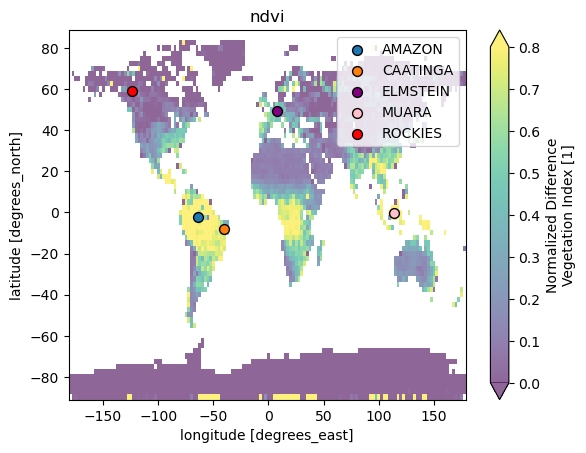

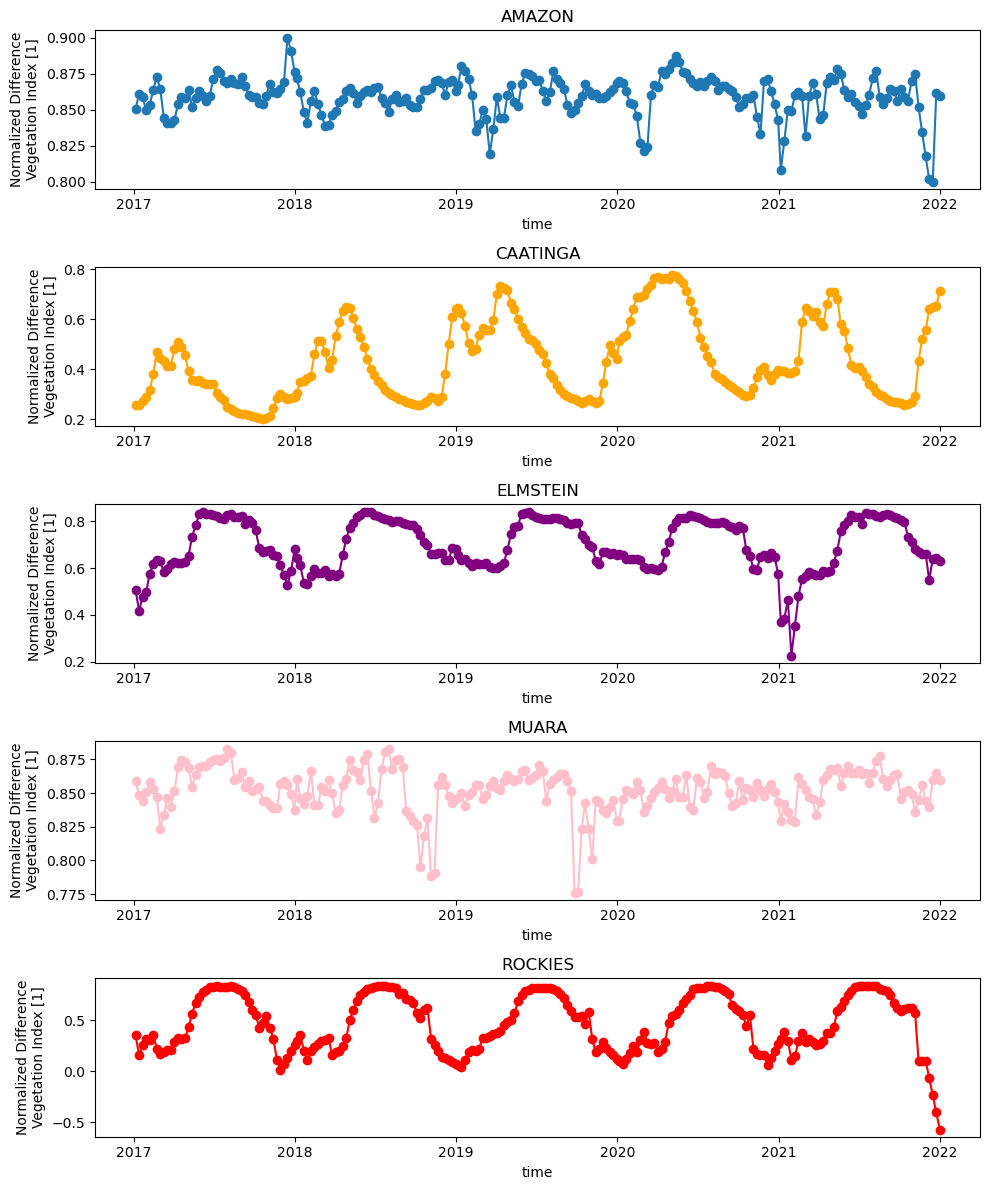

In [3]:
# Access the data:
store = new_data_store("s3", root="deep-esdl-public")
store.list_data_ids()

#Earth System Data Cube (ESDC) v3.0.1
#-------------------------------------
data_store = new_data_store("s3", root="deep-esdl-public")
dataset    = data_store.open_data( 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr')
ds         = dataset[["ndvi"]]
ds

## SELECT OUR POINTS 
#-------------------------
AMAZON = [-63.80931839570286, -2.1399049279461497]
CAATINGA = [-40.091161552570036, -7.926450359938729]
ELMSTEIN = [7.918474, 49.377749] #Germany
MUARA = [113.868742, -0.095807] #Indonesia
ROCKIES =[-123.747338,59.156882] # Canada



# Visualise our data on a map:
ds.ndvi.isel(time=-1)[::10, ::10].plot(alpha=0.6, vmin=0, vmax=0.8)
plt.scatter(AMAZON[0], AMAZON[1], label="AMAZON",s=50,edgecolors='black',
    linewidths=1,)
plt.scatter(CAATINGA[0], CAATINGA[1], label="CAATINGA",s=50,edgecolors='black',
    linewidths=1,)
plt.scatter(ELMSTEIN[0], ELMSTEIN[1], label="ELMSTEIN", s=50, edgecolors='black',
    linewidths=1, color="purple")
plt.scatter(MUARA[0], MUARA[1], label="MUARA", color="pink",s=50,edgecolors='black',
    linewidths=1,)
plt.scatter(ROCKIES[0], ROCKIES[1], label="ROCKIES", color="red",s=50,edgecolors='black',
    linewidths=1,)

plt.title("ndvi")
plt.legend()

plt.show()
plt.close()

# Let's visualise two timeseries (2017-2022) for these points:
#plt.figure()

fig, axs = plt.subplots(5, figsize=(10,12))

start_date= pd.to_datetime("2017-01-01")
end_date= pd.to_datetime("2022-01-01")


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Subset by time:
time_subsetA = ds.ndvi.sel(time=slice(start_date, end_date))



# Create Amazon timeseries
ds1dA = time_subsetA.sel(lat=AMAZON[1], lon=AMAZON[0], method="nearest")
# Plot Amazon timeseries
ds1dA.plot(label="AMAZON",color="tab:blue",marker="o",ax=axs[0])
axs[0].set_title("AMAZON")


# Create Caatinga timeseries
ds1dCA = time_subsetA.sel(lat=CAATINGA[1], lon=CAATINGA[0],method="nearest",)
# Plot Caatinga timeseries
ds1dCA.plot(label= "CAATINGA", color = "orange",marker="o",ax=axs[1])
axs[1].set_title("CAATINGA")



# Create Caatinga timeseries
ds1dE = time_subsetA.sel(lat=ELMSTEIN[1], lon=ELMSTEIN[0],method="nearest",)
# Plot Caatinga timeseries
ds1dE.plot(label= "ELMSTEIN", color = "purple",marker="o",ax=axs[2])
axs[2].set_title("ELMSTEIN")


# Create Caatinga timeseries
ds1dM = time_subsetA.sel(lat=MUARA[1], lon=MUARA[0],method="nearest",)
# Plot Caatinga timeseries
ds1dM.plot(label= "MUARA", color = "pink", marker="o",ax=axs[3])
axs[3].set_title("MUARA")


# Create Caatinga timeseries
ds1dR = time_subsetA.sel(lat=ROCKIES[1], lon=ROCKIES[0],method="nearest",)
# Plot Caatinga timeseries
ds1dR.plot(label= "ROCKIES", color = "red", marker="o",ax=axs[4])
axs[4].set_title("ROCKIES")


fig.tight_layout()
plt.show()
plt.close()




# <a id='section9'></a><span style='color:DarkCyan'> 9. Analysis cells </center> </span>


Please comment your code, describe the functions, remove dead and unreachable code.  


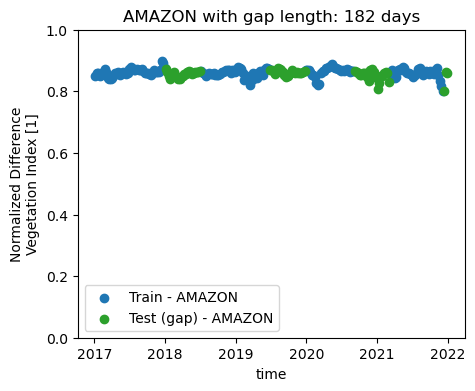

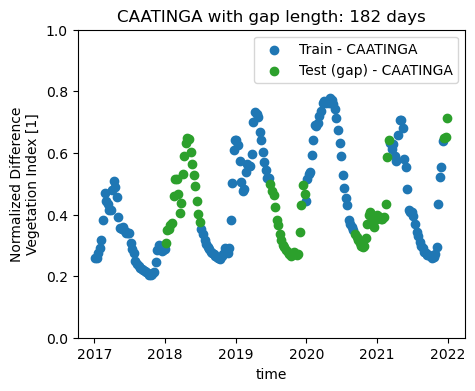

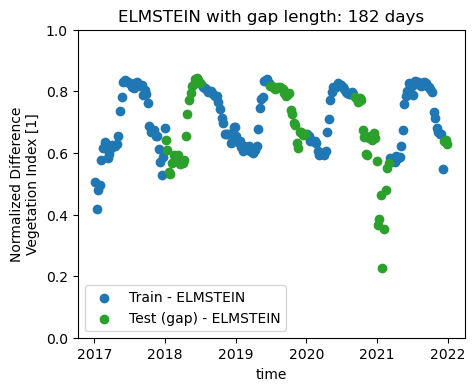

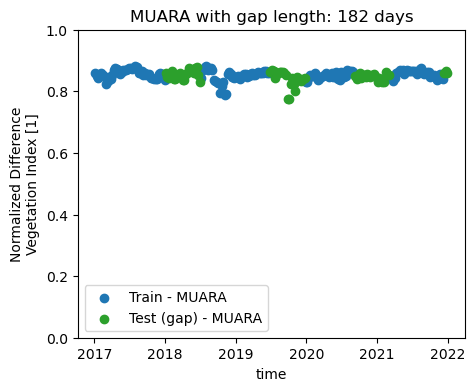

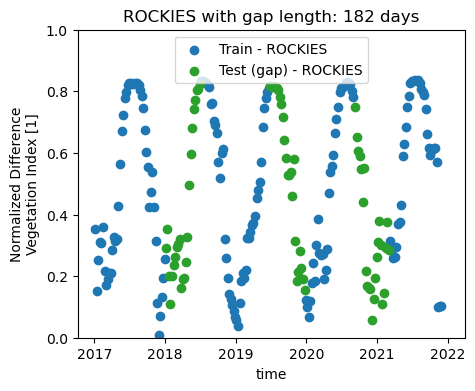

In [4]:

def generate_gaps(time_values, gap_length, unit="days", n_gaps=2, seed=42, min_spacing=0):
    """
    Generate gaps in a timeseries without overlaps and with minimum spacing.
    
    Parameters:
    - time_values: list of datetime values
    - gap_length: length of each gap
    - unit: "days", "weeks", "months"
    - n_gaps: number of gaps to generate
    - seed: random seed
    - min_spacing: minimum spacing between gaps (in same units as `unit`)
    
    Returns:
    - gaps: list of (start, end) tuples
    - actual_gap_length: length of each gap in days
    """
    rng = random.Random(seed)
    gaps = []

    # Convert time_values to sorted pandas Series
    time_series = pd.Series(pd.to_datetime(time_values)).sort_values().reset_index(drop=True)

    # Convert min_spacing to DateOffset
    if unit == "weeks":
        spacing_offset = pd.DateOffset(weeks=min_spacing)
        gap_offset = pd.DateOffset(weeks=gap_length)
        actual_gap_length = gap_length * 7
    elif unit == "months":
        spacing_offset = pd.DateOffset(months=min_spacing)
        gap_offset = pd.DateOffset(months=gap_length)
        actual_gap_length = gap_length * 30  # approximate
    else:  # days
        spacing_offset = pd.DateOffset(days=min_spacing)
        gap_offset = pd.DateOffset(days=gap_length)
        actual_gap_length = gap_length

    attempts = 0
    max_attempts = n_gaps * 20  # safety to avoid infinite loops

    while len(gaps) < n_gaps and attempts < max_attempts:
        attempts += 1
        random_start = rng.choice(time_series)
        random_end = random_start + gap_offset

        # Check for overlap with existing gaps + min_spacing
        overlap = False
        for s, e in gaps:
            buffer_start = s - spacing_offset
            buffer_end = e + spacing_offset
            if (random_start <= buffer_end) and (random_end >= buffer_start):
                overlap = True
                break

        if not overlap:
            gaps.append((random_start, random_end))

    return gaps, actual_gap_length


def subset_data_with_gaps(ds, gaps, data_name="DATASET"):
    """
    Apply gaps to a dataset and plot.

    Parameters:
    - ds: xarray dataset with time dimension
    - gaps: list of (start, end) tuples
    - data_name: string for labeling

    Returns:
    - train_set: dataset excluding gap periods
    - test_set: dataset (gap periods)
    """
    # Concatenate all gap periods into test_set
    test_sets = [ds.sel(time=slice(start, end)) for start, end in gaps]
    if test_sets:
        test_set = xr.concat(test_sets, dim="time").sortby("time")
    else:
        test_set = ds.isel(time=[])

    # Train set is everything else
    train_set = ds.sel(time=~ds['time'].isin(test_set['time'].values))

    # Compute duration of the first gap in days
    if gaps:
        first_gap_length = (gaps[0][1] - gaps[0][0]).days + 1  # +1 to include both start and end
    else:
        first_gap_length = 0

    # Plot
    plt.figure(figsize=(5, 4))
    train_set.plot.scatter(x='time', y='ndvi', color='tab:blue', label=f'Train - {data_name}')
    if len(test_set.time) > 0:
        test_set.plot.scatter(x='time', y='ndvi', color='tab:green', label=f'Test (gap) - {data_name}')
    plt.legend()
    plt.ylim(0, 1)
    plt.title(f"{data_name} with gap length: {first_gap_length} days")

    return train_set, test_set


# Choose a reference timeline (e.g., Amazon dataset)
ref_time = pd.to_datetime(ds1dA['time'].values)

# Generate shared gaps once
gaps, days = generate_gaps(ref_time, gap_length=6, unit="months", n_gaps=4, seed=18, min_spacing=2)

# Apply same gaps to all datasets
train_setA, test_setA = subset_data_with_gaps(ds1dA, gaps, "AMAZON")
train_setC, test_setC = subset_data_with_gaps(ds1dCA, gaps, "CAATINGA")
train_setE, test_setE = subset_data_with_gaps(ds1dE, gaps, "ELMSTEIN")
train_setM, test_setM = subset_data_with_gaps(ds1dM, gaps, "MUARA")
train_setR, test_setR = subset_data_with_gaps(ds1dR, gaps, "ROCKIES")


In [5]:
# We define a function to calculate processing time:

def exec_time(start, end):
    """
    This function calculates process execution time
    -----------------------------------------------
    
    input:
    - start time: start time. call with time.time()
    - end time: end of processing time. call time.time() again.

    output:
    - diff_time: time it took to run the process
    """
    
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: ", diff_time )#+ "{0:06d}:{1:06d}:{2:06d}".format(h, m, s)

    return diff_time
    


In [6]:
# Start time counter
start = time.time()

def interpolation(TYPE, location):
    start = time.time()
    
    """
    A function that interpolates our timeseries data.
    Input:
    - TYPE: choose among "linear", 
    - location: pick our location

    output:
    - dfmetrics: a dataframe of accuracy metrics
    
    """
    if location == "Amazon":
        train_set = train_setA
        test_set = test_setA
        
    elif location == "Caatinga":
        train_set = train_setC
        test_set = test_setC
            
    elif location == "Elmstein":
        train_set = train_setE
        test_set = test_setE
        
        
    elif location == "Muara":
        train_set = train_setM
        test_set = test_setM
    
    elif location == "Rockies":
        train_set = train_setR
        test_set = test_setR
        
    # numeric time for interpolation
    train_time_num = (train_set.time.astype("int64") // 10**6).astype("int64").values
    test_time_num = (test_set.time.astype("int64") // 10**6).astype("int64").values

    # datetime for plotting
    train_time_dt = train_set.time.values
    test_time_dt = test_set.time.values
    

    # interpolation
    if TYPE == "linear":
        f = interp1d(train_time_num, train_set.values, kind=TYPE, fill_value="extrapolate")
        interpolated_values = f(test_time_num)
        
        # plot with datetime
        plt.figure(figsize=(6, 5))
        plt.scatter(train_time_dt, train_set.values, label="train")
        plt.scatter(test_time_dt, interpolated_values, label="interpolated")
        plt.scatter(test_time_dt, test_set.values, label="real")

        plt.title(TYPE +" interpolation - " + location )
        plt.xlabel("Time")
        plt.ylabel("Values")

        # format x-axis as dates
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gcf().autofmt_xdate()

        plt.legend()
        #plt.show()
        
        R2 = r2_score(test_set.values, interpolated_values)
        RMSE = root_mean_squared_error(test_set.values, interpolated_values)
        MAPE = mean_absolute_percentage_error(test_set.values, interpolated_values)

        end = time.time()
        T =exec_time(start,end)

        dfmetrics = {"R2": R2, "RMSE":RMSE, "MAPE":MAPE, "days":days, "kind":TYPE, "time": T, "location": location}
        
        #plt.savefig("Linear_"+str(days)+"_"+location+".png", dpi=400)
        
    #Cubic Spline interpolation  
    if TYPE == "CubicSpline":
        f = CubicSpline((train_set.time.astype("int64")//10**6).astype("int64").values, train_set.values)  # 'linear' interpolation
        interpolated_values = f(test_time_num)
        
        # plot with datetime
        plt.figure(figsize=(6, 5))
        plt.scatter(train_time_dt, train_set.values, label="train")
        plt.scatter(test_time_dt, interpolated_values, label="interpolated")
        plt.scatter(test_time_dt, test_set.values, label="real")

        plt.title(TYPE +" interpolation - " + location )
        plt.xlabel("Time")
        plt.ylabel("Values")

        # format x-axis as dates
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gcf().autofmt_xdate()

        plt.legend()
        #plt.show()
        
        R2 = r2_score(test_set.values, interpolated_values)
        RMSE = root_mean_squared_error(test_set.values, interpolated_values)
        MAPE = mean_absolute_percentage_error(test_set.values, interpolated_values)

        end = time.time()
        T =exec_time(start,end)

        dfmetrics = {"R2": R2, "RMSE":RMSE, "MAPE":MAPE, "days":days, "kind":TYPE, "time": T, "location": location}
        
        #plt.savefig("Cubic_"+str(days)+"_"+location+".png", dpi=400)
        
    
    #Gaussian Process Regression interpolation
    if TYPE == "GPR":
        start = time.time()

        # --- Convert train time to numeric days ---
        X_raw = train_set.time.values.astype("int64") // 10**9
        X_days = (X_raw - X_raw.min()) / (60*60*24)

        y = train_set.values
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()

        # Mask observed values
        observed_mask = ~np.isnan(y)
        X_train = X_days[observed_mask].reshape(-1, 1)
        y_train = y[observed_mask]

        # --- Full timeline for prediction ---
        train_time_series = pd.Series(train_set.time.values)
        test_time_series = pd.Series(test_set.time.values)
        full_time = pd.concat([train_time_series, test_time_series]).sort_values().reset_index(drop=True)

        #convert date to a better format for GPR
        X_full = (full_time.values.astype("int64") // 10**9 - X_raw.min()) / (60*60*24)
        X_full = X_full.reshape(-1, 1)

        # --- Fit Gaussian Process ---
        # Pick our kernels: 
        #  RBF to account for smoothness,
        #  ExpSineSquared to account for seasonality
        #  WhiteKernel to accoutn for noise  
        kernel = RBF(length_scale=50.0) + ExpSineSquared(length_scale=50.0, periodicity=365.0) + WhiteKernel(noise_level=0.01)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
        gp.fit(X_train, y_train)

        # --- Predict over full timeline ---
        y_pred, y_std = gp.predict(X_full, return_std=True)

        # --- Plot scatter like other methods ---
        plt.figure(figsize=(6,5))
        plt.scatter(train_set.time, train_set.values, label="train", color="tab:blue", s=20)
        plt.scatter(full_time, y_pred, label="interpolated (GPR)", color="tab:orange", s=20)
        plt.scatter(test_set.time, test_set.values, label="real", color="green", s=20)

        # Confidence interval
        plt.fill_between(full_time,
                         y_pred - 2*y_std,
                         y_pred + 2*y_std,
                         color="tab:orange", alpha=0.2, label="±2σ") #95% CI

        plt.title(f"GPR interpolation - {location}")
        plt.xlabel("Time")
        plt.ylabel("Values")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gcf().autofmt_xdate()
        plt.legend()
        #plt.show()

        # --- Metrics on test set only ---
        X_test = (test_set.time.values.astype("int64") // 10**9 - X_raw.min()) / (60*60*24)
        X_test = X_test.reshape(-1, 1)
        y_test = test_set.values
        if hasattr(y_test, "to_numpy"):
            y_test = y_test.to_numpy()
        y_test_pred, _ = gp.predict(X_test, return_std=True)

        R2 = r2_score(y_test, y_test_pred)
        RMSE = root_mean_squared_error(y_test, y_test_pred)
        MAPE = mean_absolute_percentage_error(y_test, y_test_pred)

        end = time.time()
        T = exec_time(start, end)

        dfmetrics = {"R2": R2, "RMSE": RMSE, "MAPE": MAPE, "days": days, "kind": TYPE, "time": T, "location": location}

        #plt.savefig("GPR_"+str(days)+"_"+location+".png", dpi=400)
        
    # --- Seasonal interpolation (with past and future window) ---
    elif TYPE == "Seasonal":
        
        window_days=7
        train_df = pd.DataFrame({"time": train_time_dt, "value": train_set.values})
        train_df["doy"] = train_df["time"].dt.dayofyear
        test_time_dt1 = pd.to_datetime(test_time_dt)
        interpolated_values = []

        for t in test_time_dt1:
            doy_t = t.timetuple().tm_yday
            
            # Windowed selection
            window_vals = train_df[(train_df["doy"] >= doy_t - window_days) & (train_df["doy"] <= doy_t + window_days)]["value"]
            
            if len(window_vals) > 0:
                interpolated_values.append(window_vals.mean())
            else:
                diffs = np.abs(train_df["doy"] - doy_t)
                idx_min = diffs.idxmin()
                interpolated_values.append(train_df.loc[idx_min, "value"])

        interpolated_values = np.array(interpolated_values)

        plt.figure(figsize=(6, 5))
        plt.scatter(train_time_dt, train_set.values, label="train")
        plt.scatter(test_time_dt, interpolated_values, label="interpolated (seasonal)", color="tab:orange")
        plt.scatter(test_time_dt, test_set.values, label="real", color="green")
        plt.title("Seasonal interpolation - " + location)
        plt.xlabel("Time")
        plt.ylabel("Values")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gcf().autofmt_xdate()
        plt.legend()
        #plt.show()

        R2 = r2_score(test_set.values, interpolated_values)
        RMSE = root_mean_squared_error(test_set.values, interpolated_values)
        MAPE = mean_absolute_percentage_error(test_set.values, interpolated_values)
        end = time.time()
        T = exec_time(start, end)

        dfmetrics = {"R2": R2, "RMSE": RMSE, "MAPE": MAPE, "days":days, "kind":TYPE, "time": T, "location": location}
        #plt.savefig("Seasonal_"+str(days)+"_"+location+".png", dpi=400)
        

    return dfmetrics


Execution Time:  0.35504698753356934
Execution Time:  0.6290695667266846
Execution Time:  0.37151408195495605
Execution Time:  0.4424552917480469
Execution Time:  0.5377426147460938


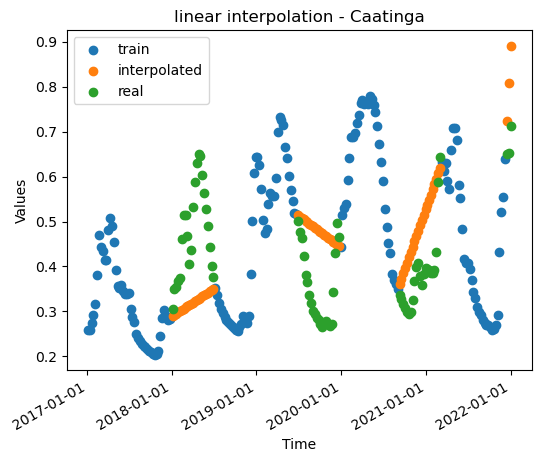

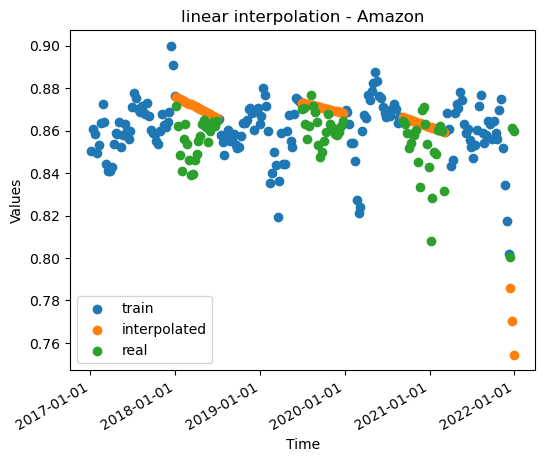

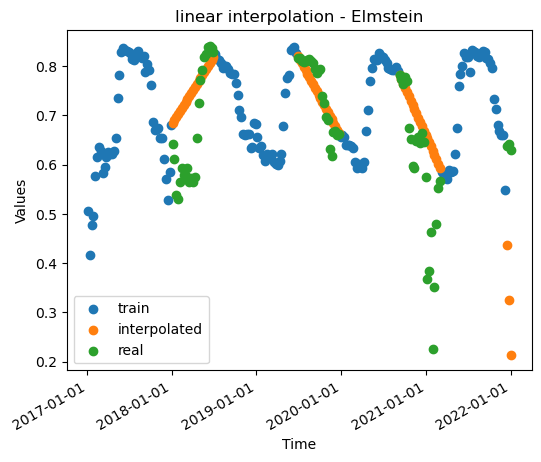

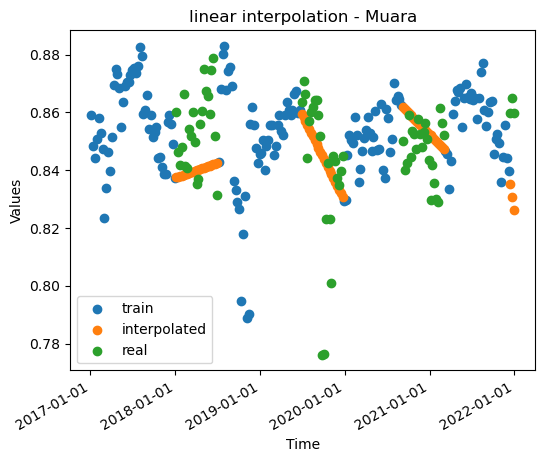

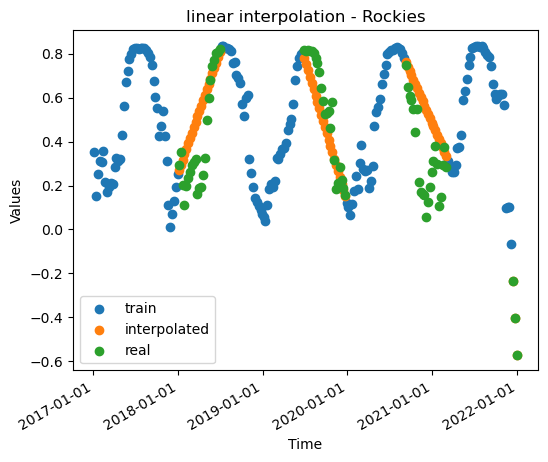

In [7]:
#LINEAR INTERPOLATION
LC = interpolation("linear", "Caatinga")
LA = interpolation("linear", "Amazon")
LE =interpolation("linear", "Elmstein")
LM = interpolation("linear", "Muara")
LR = interpolation("linear", "Rockies")


Execution Time:  0.38396620750427246
Execution Time:  0.6379997730255127
Execution Time:  0.3731379508972168
Execution Time:  0.44517946243286133
Execution Time:  0.5438599586486816


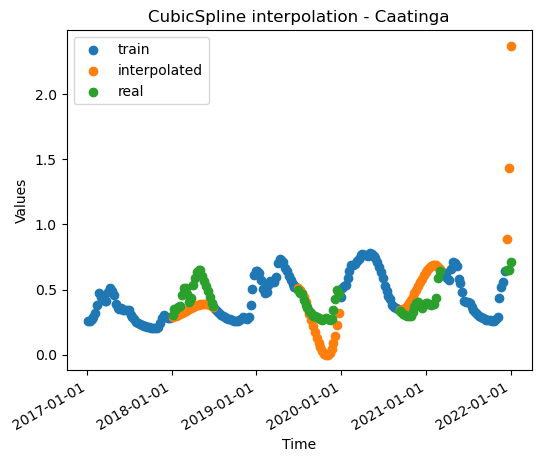

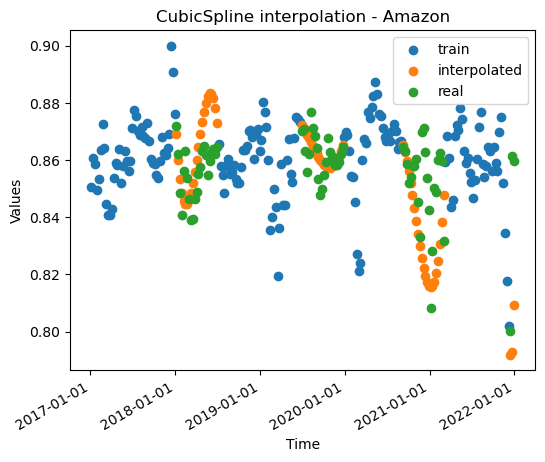

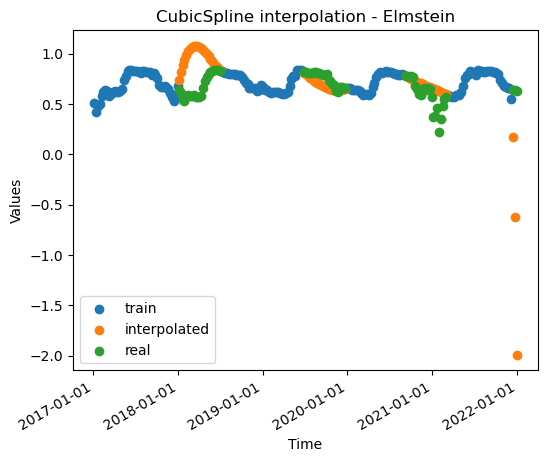

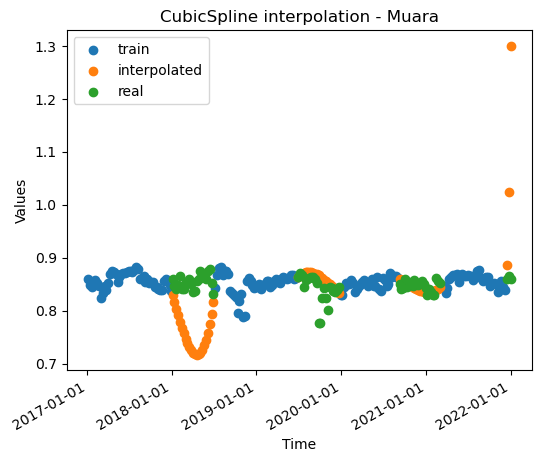

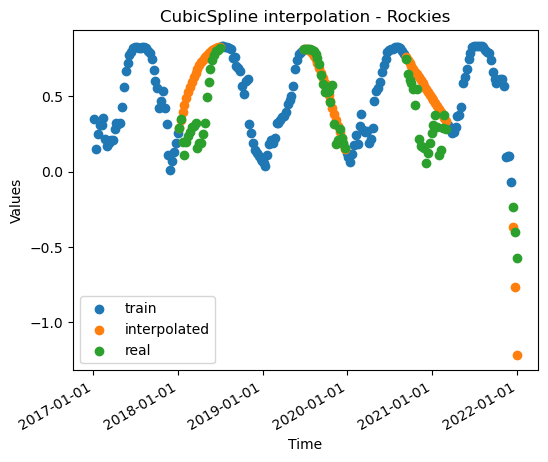

In [9]:
#CUBIC SPLINE INTERPOLATION
CC = interpolation("CubicSpline", "Caatinga")
CA =interpolation("CubicSpline", "Amazon")
CE =interpolation("CubicSpline", "Elmstein")
CM =interpolation("CubicSpline", "Muara")
CR =interpolation("CubicSpline", "Rockies")


Execution Time:  0.8819622993469238


/home/conda/users/fbfe84b6-1757499783-109-science-hub-course-updated/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Execution Time:  1.1756927967071533


/home/conda/users/fbfe84b6-1757499783-109-science-hub-course-updated/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Execution Time:  1.2742934226989746


/home/conda/users/fbfe84b6-1757499783-109-science-hub-course-updated/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/conda/users/fbfe84b6-1757499783-109-science-hub-course-updated/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Execution Time:  1.1290569305419922
Execution Time:  1.4447743892669678


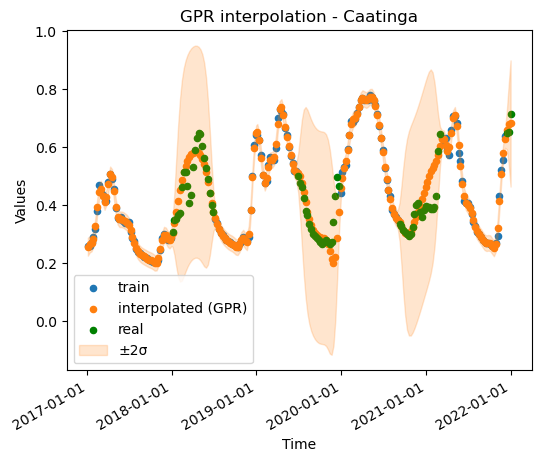

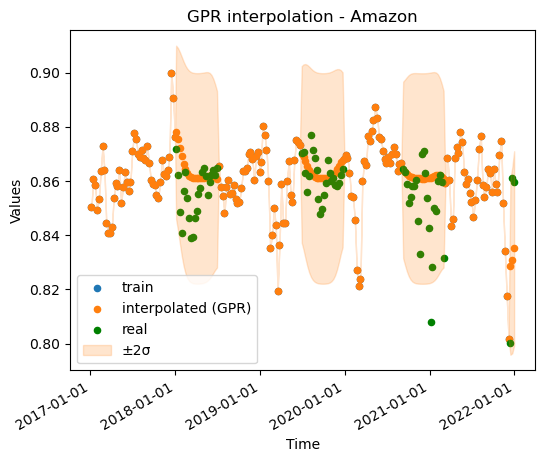

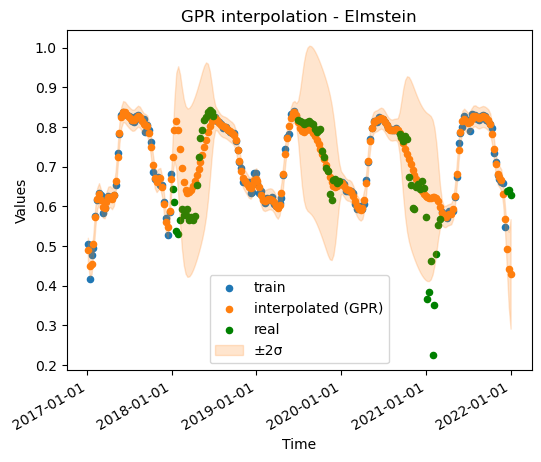

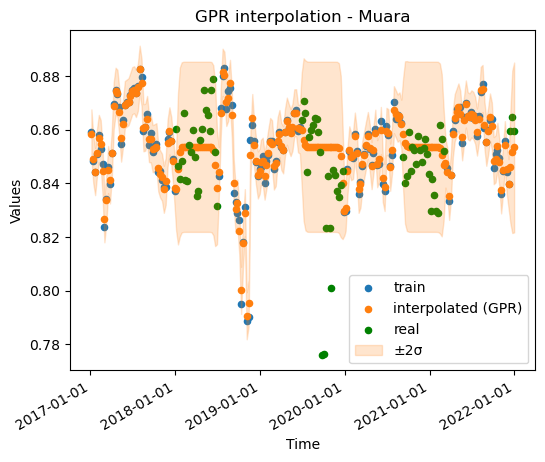

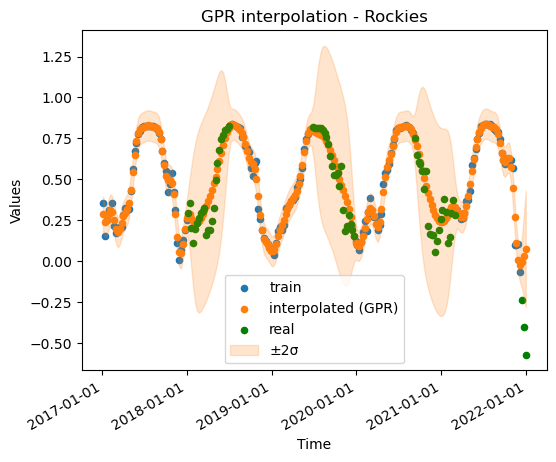

In [10]:
GC = interpolation("GPR", "Caatinga")
GA = interpolation("GPR", "Amazon")
GE = interpolation("GPR", "Elmstein")
GM = interpolation("GPR", "Muara")
GR = interpolation("GPR", "Rockies")


Execution Time:  0.3807833194732666
Execution Time:  0.6626808643341064
Execution Time:  0.3941342830657959
Execution Time:  0.4735894203186035
Execution Time:  0.5647144317626953


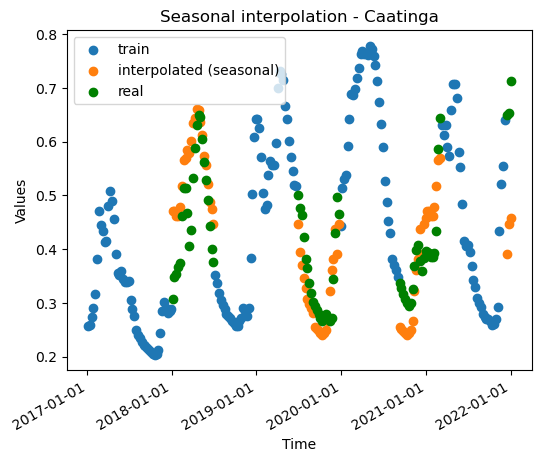

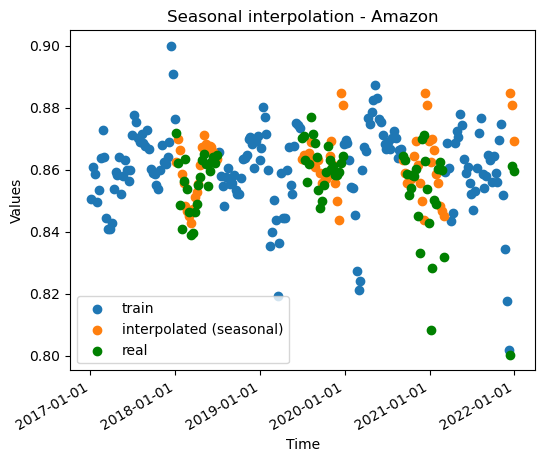

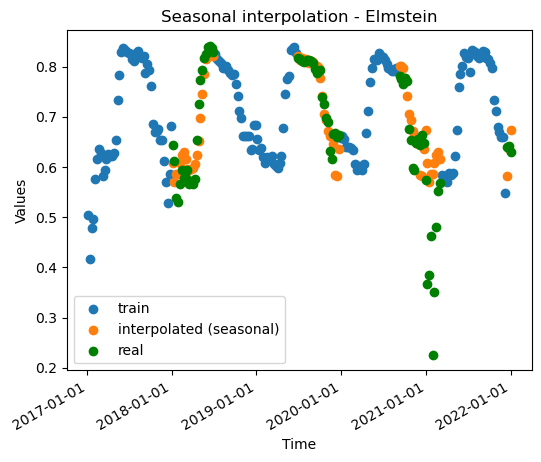

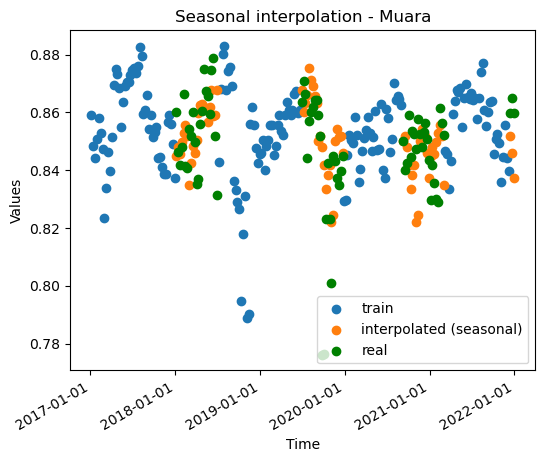

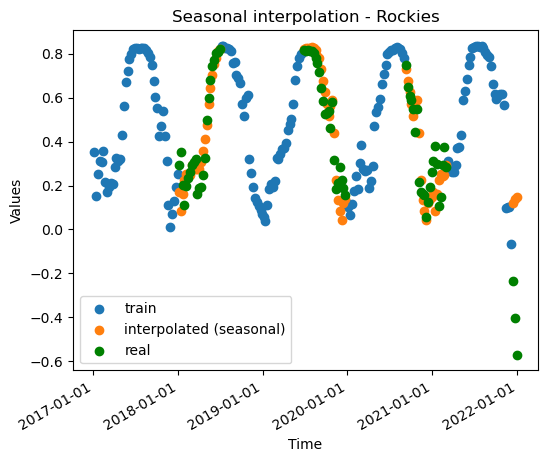

In [11]:
SC = interpolation("Seasonal", "Caatinga")
SA = interpolation("Seasonal", "Amazon")
SE = interpolation("Seasonal", "Elmstein")
SM =interpolation("Seasonal", "Muara")
SR =interpolation("Seasonal", "Rockies")


In [12]:
# collate all metrics ! 
metrics = [LA, LC, LE, LM, LR, 
           CA, CC, CE, CM, CR,
            SC, SA, SE, SM ,SR,
           GA, GC, GE, GM, GR]


DFmetrics = pd.DataFrame(metrics)

#divide time by 10 to make it fit into plot
DFmetrics.time=DFmetrics.time/10
DFmetrics

,R2,RMSE,MAPE,days,kind,time,location
0,-2.071670,0.022765,0.017272,180,linear,0.062907,Amazon
1,-0.783645,0.154162,0.344884,180,linear,0.035505,Caatinga
2,0.064498,0.125736,0.165355,180,linear,0.037151,Elmstein
3,-0.160626,0.019588,0.017285,180,linear,0.044246,Muara
4,0.556621,0.193512,0.710559,180,linear,0.053774,Rockies
5,-1.203839,0.019283,0.015733,180,CubicSpline,0.063800,Amazon
6,-4.664079,0.274719,0.410980,180,CubicSpline,0.038397,Caatinga
7,-8.888681,0.408797,0.358573,180,CubicSpline,0.037314,Elmstein
8,-20.002818,0.083325,0.058022,180,CubicSpline,0.044518,Muara
9,0.283473,0.246001,0.853321,180,CubicSpline,0.054386,Rockies


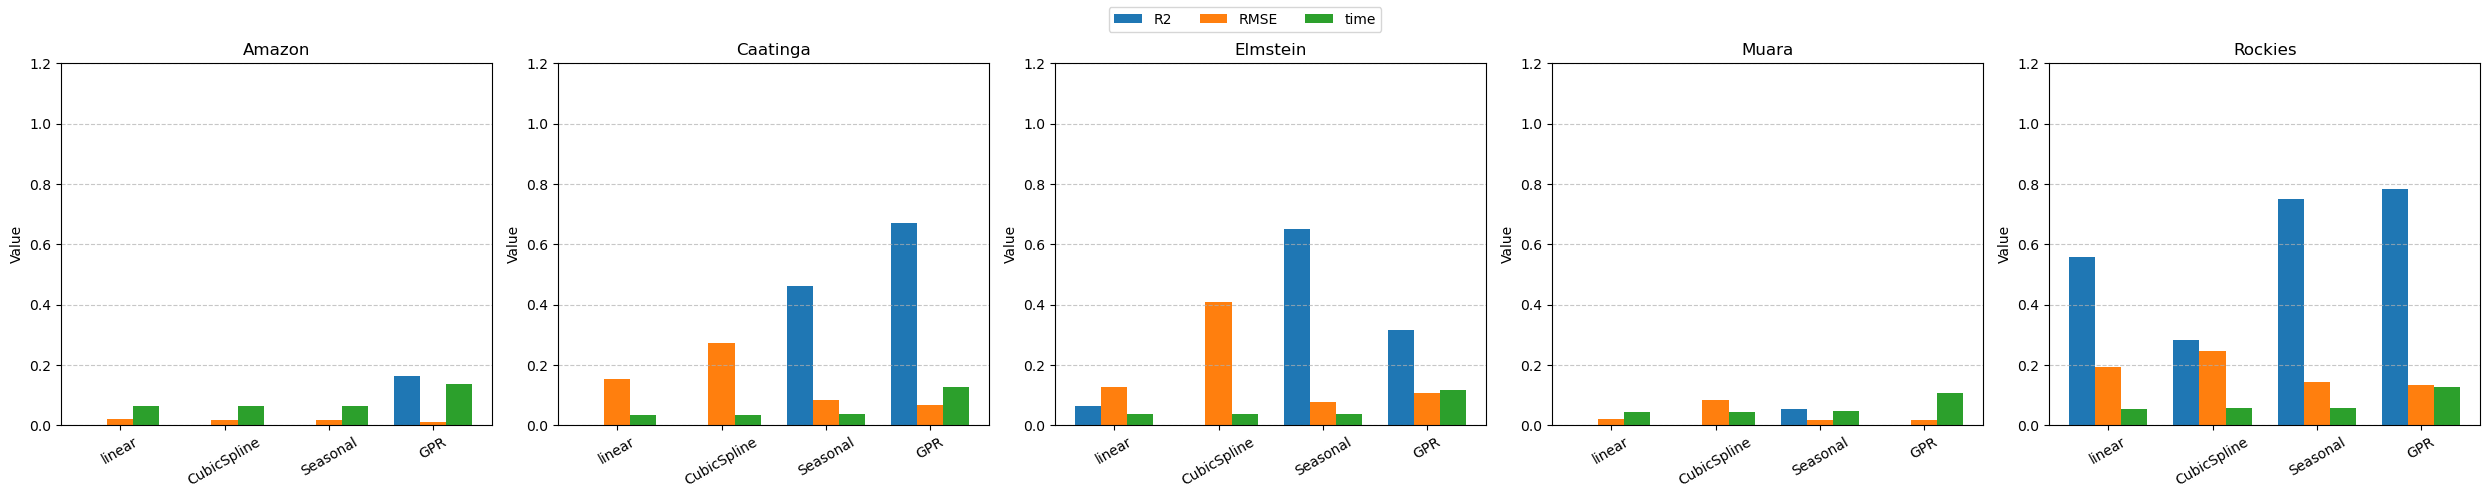

In [83]:
df = DFmetrics
metrics = ["R2","RMSE", "time"]
locations = df["location"].unique()

fig, axes = plt.subplots(1, len(locations), figsize=(5*len(locations), 5), sharey=False)

for i, loc in enumerate(locations):
    sub = df[df["location"] == loc]
    
    # x positions = kinds
    kinds = sub["kind"].unique()
    x = np.arange(len(kinds))
    width = 0.25  # width of each bar
    
    for j, metric in enumerate(metrics):
        axes[i].bar(x + j*width, sub[metric], width, label=metric)
    
    axes[i].set_title(loc)
    axes[i].set_ylim(0,1.2)
    axes[i].set_xticks(x + width)
    axes[i].set_xticklabels(kinds, rotation=30)
    axes[i].set_ylabel("Value")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)


# put one legend for all
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(metrics))

plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig("Summary_"+str(days)+"days.png", dpi=300)